In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/test2classes.zip" "test2classes.zip"
!cp "/content/drive/My Drive/Histopathology data/AlexNetdualmodel.pth" "AlexNetdualmodel.pth"

In [ ]:
!unzip -q test2classes.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # 
batch_size_test = 100 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets

test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


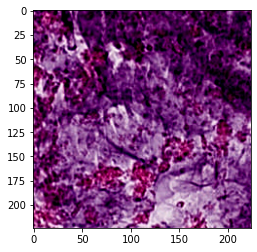

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Here I have used Alexnet architecture pre-trained on Imagenet Dataset

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        from torchvision import models
        # downloading pretrained model from torchvision
        alexnet = models.alexnet(pretrained=True)
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = alexnet.classifier
        self.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet4(2)
model.load_state_dict(torch.load('AlexNetdualmodel.pth', map_location=device))
model=model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
   
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    y=[]
    y_pred=[]
    prob=[]
    for data, target in test_loader:
        t=target.tolist()
        y.append(t)
        data, target = data.to(device), target.to(device) 
        
        with torch.no_grad():
            
            output = model(data)
        p=output.tolist()
        prob.append(p)     
        # compute the loss function
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        m=pred.tolist()
        y_pred.append(m) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg, y,y_pred,prob

In [ ]:
import os.path
from os import path



stl,acct,y,y_pred,prob=test(model, device, test_loader)

print('average accuracy: ',acct)

Test: Average loss: 0.1242, Accuracy: 6868/7200 (95.39%)

average accuracy:  95.38888888888889


In [ ]:
flat_prob=[element for sublist in prob for element in sublist]
proba=np.array(flat_prob)
flatten_y = [element for sublist in y for element in sublist]
flatten_y_pred = [element for sublist in y_pred for element in sublist]
flatten_y_pred = [element for sublist in flatten_y_pred for element in sublist]

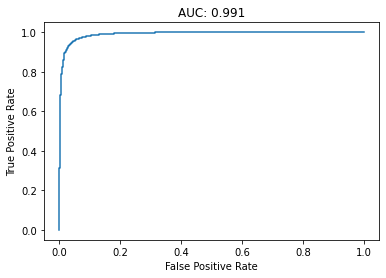

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba = proba[::,1]
fpr, tpr, thresholds = roc_curve(flatten_y, y_pred_proba)
auc = roc_auc_score(flatten_y, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC: %.3f' % auc)
plt.show()

In [ ]:
fpr=str(fpr)
tpr=str(tpr)

output_file = open('googlenet_fpr.txt', 'w')

for t in fpr:
    output_file.write(t)

output_file.close()


output_file = open('googlenet_tpr.txt', 'w')

for t in tpr:
    output_file.write(t)

output_file.close()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision=precision_score(flatten_y, flatten_y_pred)
precision=precision*100
print(precision)

94.16216216216216


In [ ]:
recall=recall_score(flatten_y, flatten_y_pred)
recall=recall*100
print(recall)

96.77777777777777


In [ ]:
f1=f1_score(flatten_y, flatten_y_pred)
f1=f1*100
print(f1)

95.45205479452055
